In [441]:
Patient = "P007" #"P015/P015_S01_D2024-07-06"
run = None




2025-05-02 14:15:14,444 - INFO - Using device: cpu


Intervall: 60000 - 70000


2025-05-02 14:15:15,177 - INFO - Loaded primary TDMS file: Data/P007/P007_S01_D2024-04-11.tdms
2025-05-02 14:15:15,438 - INFO - Loaded additional TDMS file: Data/P007/P007_S01_D2024-04-11_addCh.tdms
2025-05-02 14:15:15,440 - INFO - Loaded sensor log file: Data/P007/QZFM_log_file.txt
2025-05-02 14:15:15,440 - INFO - Available runs: Brust, Ruecken, Leermessung
2025-05-02 14:15:15,465 - INFO - Model loaded from MCG_segmentation/MCGSegmentator_s/checkpoints/best/model.pth


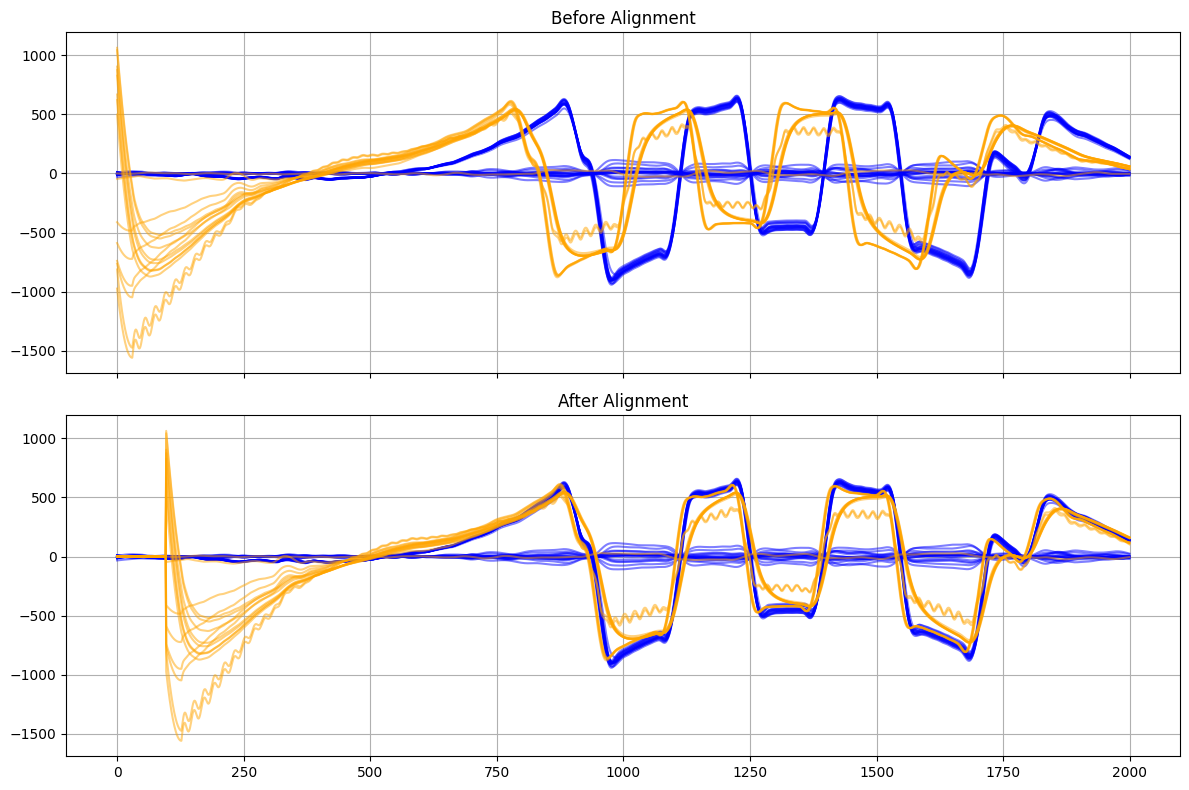

In [442]:
import importlib
import analyzer
importlib.reload(analyzer)

from analyzer import Analyzer
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import json



def load_patient_data(patient: str, run: str = None):
    """
    Load patient data from the specified file.
    """

    overview = pd.read_excel("Data/overview.xlsx")
    dir = "Data/" + patient + "/"
    number = re.findall(r'\d+', dir)
    patient_number = int(number[0]) if number else None


    if overview.loc[overview["Probanten Nr."] == patient_number, "runs"].values[0].strip() == "-":
        print(f"No runs found for patient {patient_number}. Skipping...")
        return
    
    add_filename, file_name = None, None
    
    for file in os.listdir(dir):
        if file.endswith(".tdms") and file.startswith(patient):
            if run and run not in file:
                continue
            if "addCh" in file:
                add_filename = os.path.join(dir, file)
            else:
                file_name = os.path.join(dir, file)
            
    
    log_file_path = os.path.join(dir, "QZFM_log_file.txt")
    sensor_channels_to_exclude = json.loads(overview.loc[overview["Probanten Nr."] == patient_number, "Sensors to exclude"].values[0])

    
    intervall = overview.loc[overview["Probanten Nr."] == patient_number, "Intervall"].values[0]
    intervall = intervall.split(":") if isinstance(intervall, str) else intervall
    intervall_start = int(intervall[0]) if isinstance(intervall, list) else None
    intervall_end = int(intervall[1]) if isinstance(intervall, list) else None
    print(f"Intervall: {intervall_start} - {intervall_end}")

    return Analyzer(
        filename=file_name,
        add_filename=add_filename,
        log_file_path=log_file_path,
        sensor_channels_to_exclude=sensor_channels_to_exclude
    ), intervall_start, intervall_end

analysis, intervall_start, intervall_end = load_patient_data(Patient, run)

for k in analysis.key_list:
    if k in ["Brustlage", "Brust", "Bauchlage", "Bauch"]:
        key = k
        break
    
(x_data, y_data, z_data), time, single_run = analysis.prepare_data(key, apply_default_filter=True, plot_alignment=True)




# Testing model segmentation

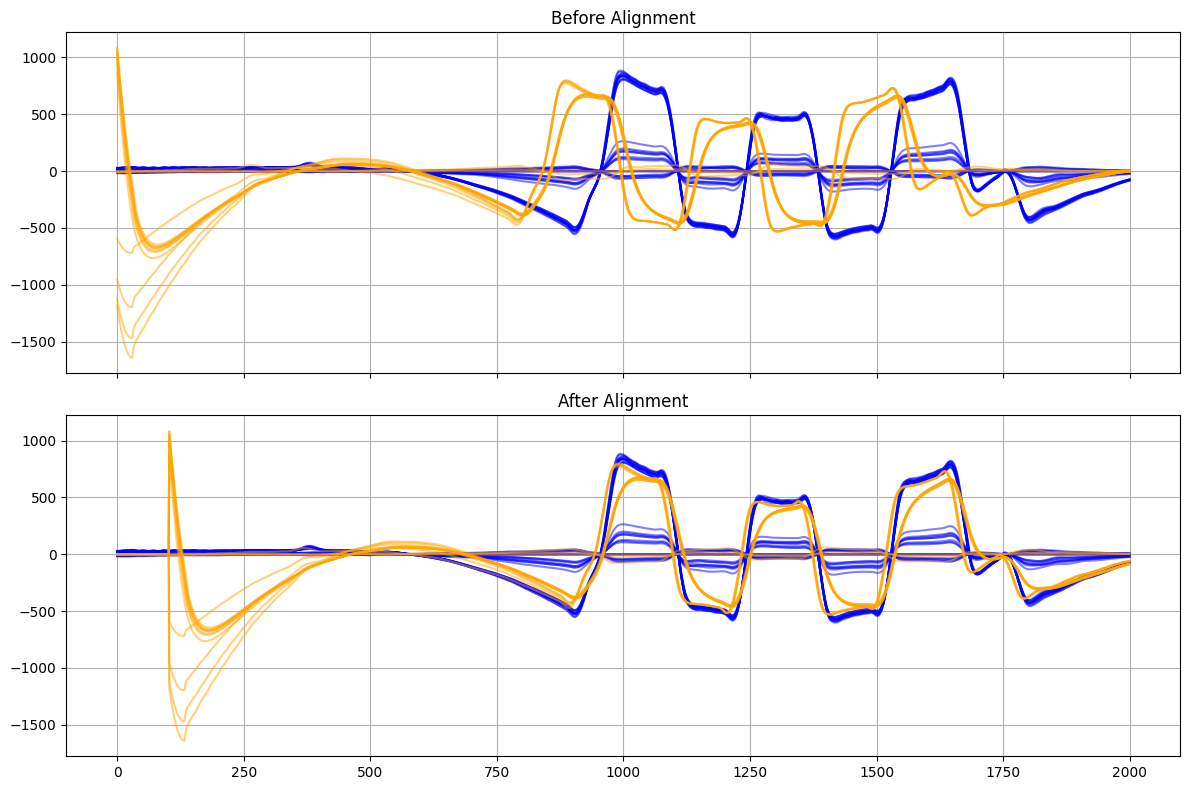

KeyboardInterrupt: 

In [263]:

(x_data, y_data, z_data), time, single_run = analysis.prepare_data(key, apply_default_filter=True, plot_alignment=True)


S_ica = analysis.apply_ICA(y_data)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,10), sharex=True)
for i, ax in enumerate(axes.flat):
    if i >= len(S_ica):
        break
    ax.plot(S_ica[i][1000:5000])
    ax.set_title(f"IC {i+1}")
plt.suptitle(f"Unabhängige Komponenten (ICA) – x-Komponente, {key}")
plt.tight_layout()
plt.show()



labels, data, confidence = analysis.segment_entire_run(S_ica[:, 1000:5000])

argmax, _ = analysis.find_cleanest_channel(S_ica[:, 1000:3000])


analysis.plot_segmented_signal(data[argmax, :], labels[argmax, :])

Improve Windowing

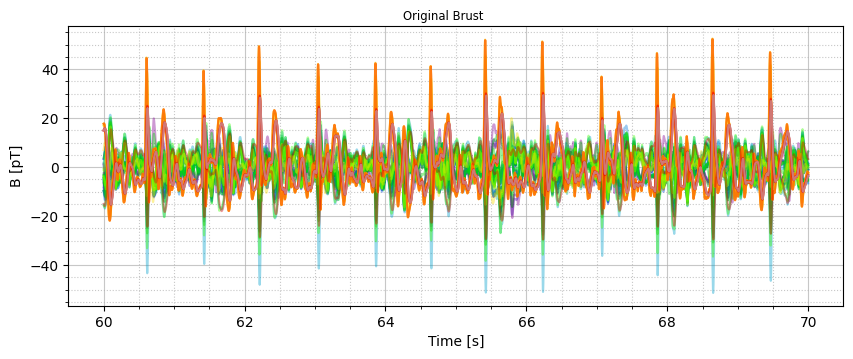

Heart Rate: 74.59 bpm
Heart Rate Variability (SDNN): 21.61 ms
Number of detected peaks: 12
Number of plausible RR intervals used: 11


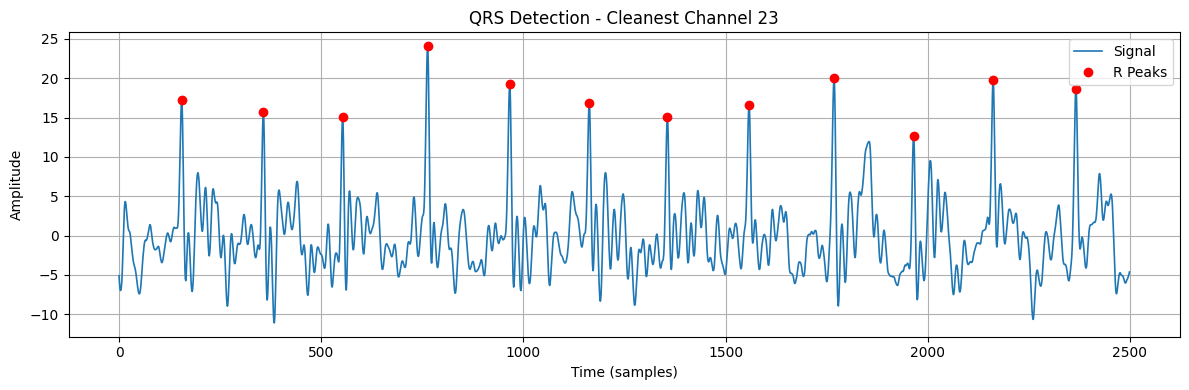

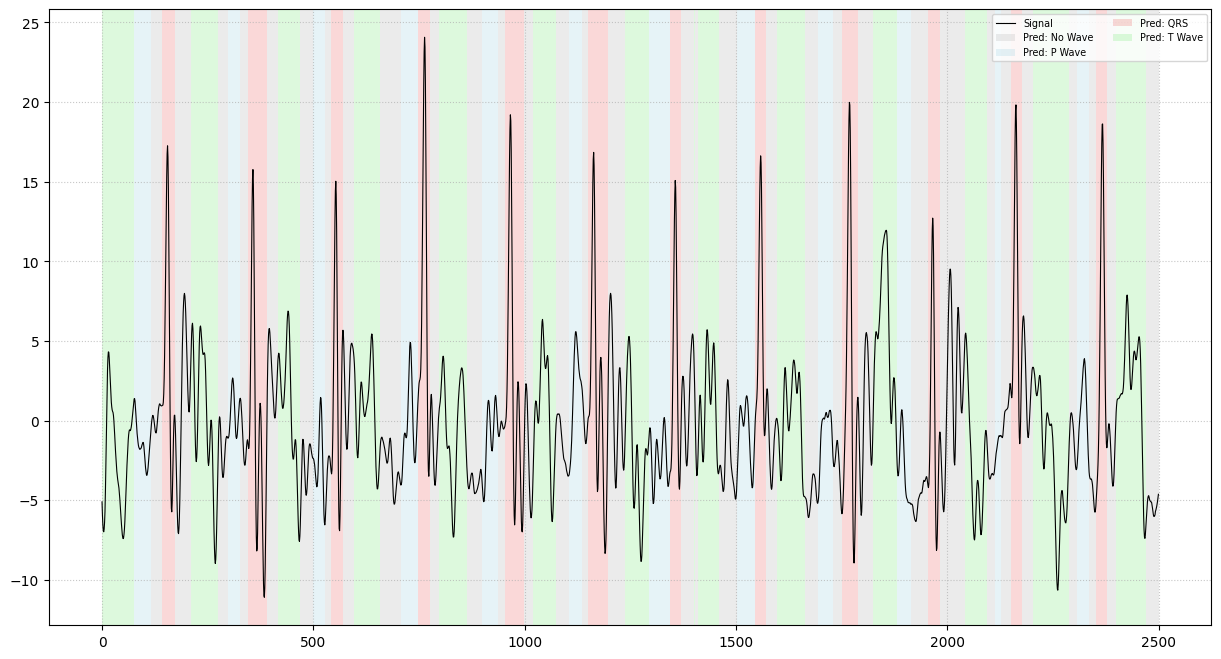

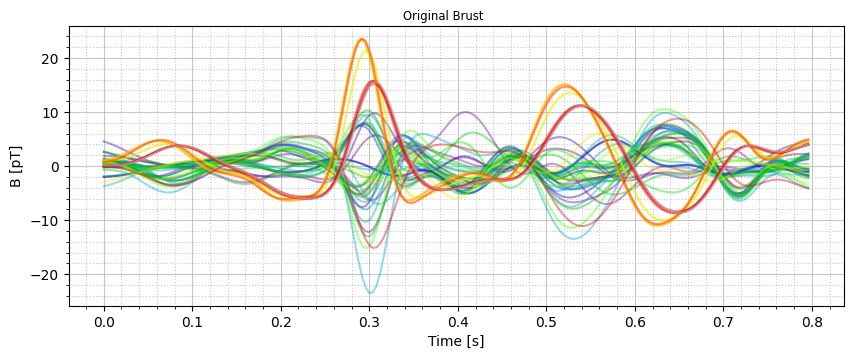

In [443]:

_data = single_run[:, intervall_start:intervall_end]

analysis.plotting_time_series(_data, time[intervall_start:intervall_end], 48, f"Original {key}")



# use cleanest channel for peak detection
peak_positions, resampled_data, ch, labels, _, _ = analysis.detect_qrs_complex_peaks_cleanest_channel(single_run[:, intervall_start:intervall_end], print_heart_rate=True, confidence_threshold=0.7)
if peak_positions is not None and len(peak_positions) > 0:
    plt.figure(figsize=(12, 4))
    plt.plot(resampled_data[ch, :], label='Signal', linewidth=1.2)
    #plt.plot(resampled_data[ch, :], label='Signal', linewidth=1.2)
    plt.plot(peak_positions, resampled_data[ch, peak_positions], "ro", markersize=6, label='R Peaks')
    plt.title(f"QRS Detection - Cleanest Channel {ch + 1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No R peaks detected or `peak_positions` is empty.")
analysis.plot_segmented_signal(resampled_data[ch, :], labels[ch, :])

# window averaging
avg_channels, time_window = analysis.avg_window(resampled_data, peak_positions, window_left=0.3, window_right=0.5)
analysis.plotting_time_series(avg_channels, time_window, 48, f"Original {key}")



## Test Magnetic Moment fit

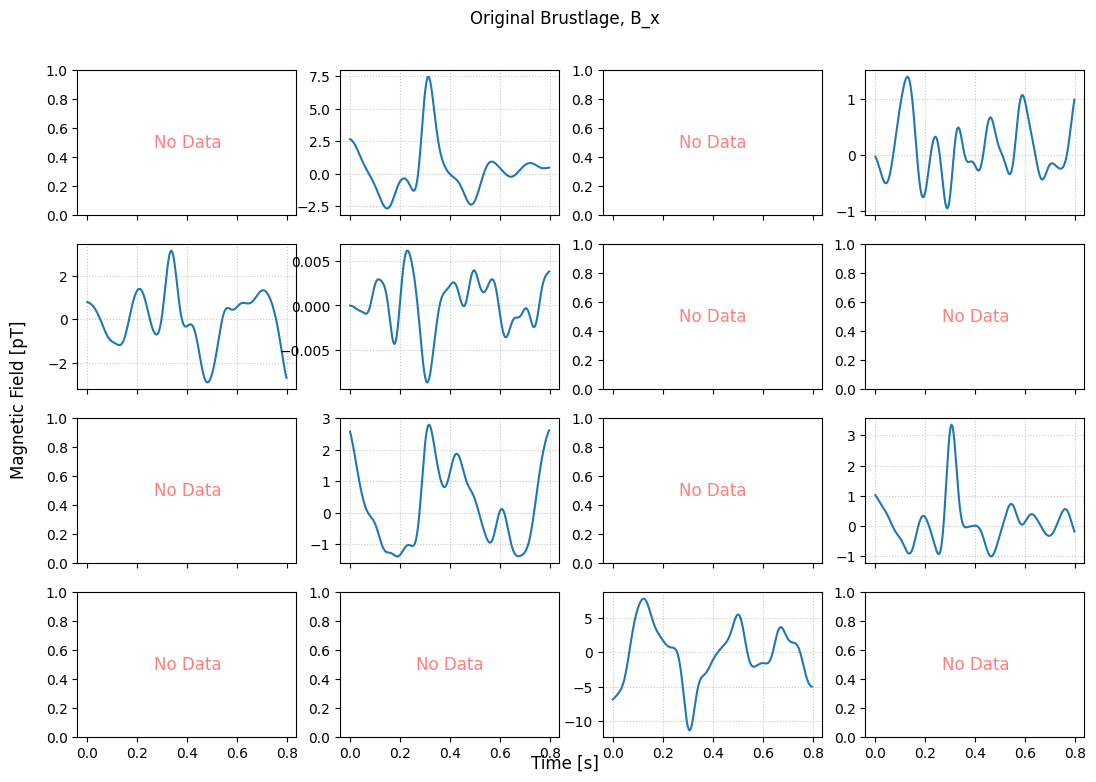

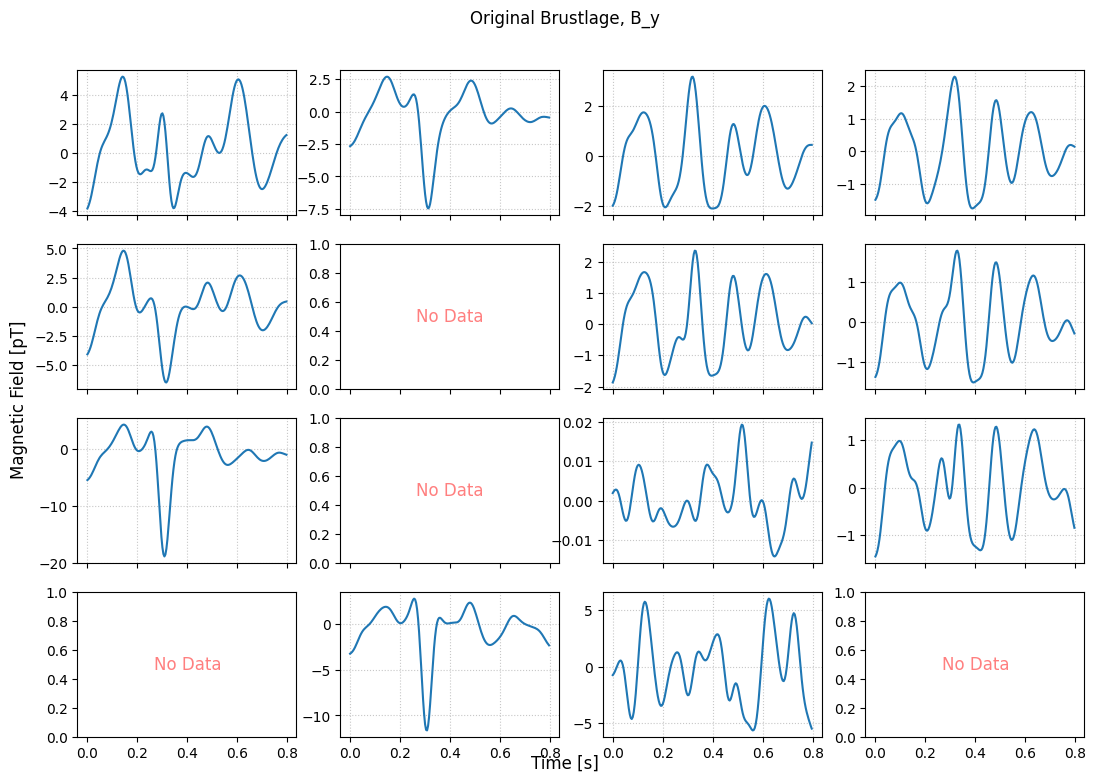

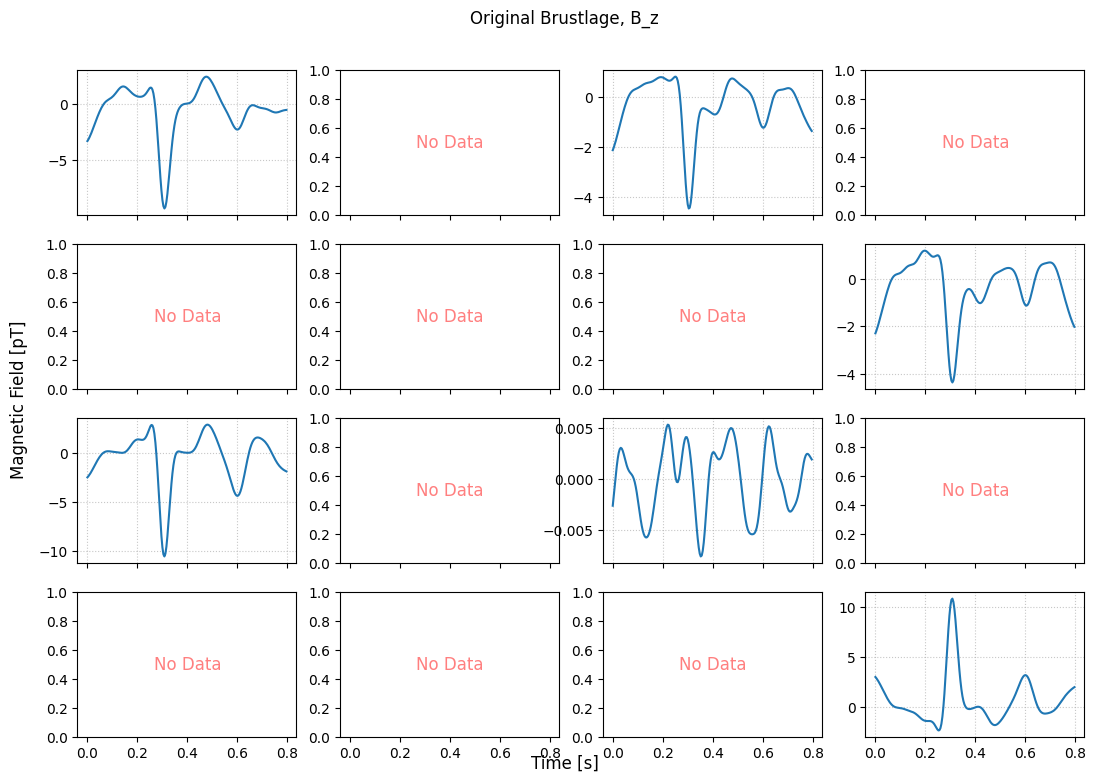

(4, 4, 200) (4, 4, 200) (4, 4, 200)
Fitted time 0/200
Fitted time 100/200


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d

def gaussian_smoothing(x, sigma=2):
    """Gaussian smoothing along time axis."""
    x_smooth = gaussian_filter1d(x, sigma=sigma, axis=-1, mode='nearest')
    return x_smooth


# --- Load data ---
x_data, y_data, z_data = analysis.get_field_directions(avg_channels, key)

analysis.plot4x4(x_data, time_window, f"Original {key}, B_x")
analysis.plot4x4(y_data, time_window, f"Original {key}, B_y")
analysis.plot4x4(z_data, time_window, f"Original {key}, B_z")

print(x_data.shape, y_data.shape, z_data.shape)

# --- Constants and grid ---
grid_spacing = 25.3e-3  # 25.3 mm
MU_0 = 4 * np.pi * 1e-7  # T·m/A

x = np.arange(4) * grid_spacing
y = np.arange(4) * grid_spacing
X, Y = np.meshgrid(x, y)
sensor_positions_np = np.stack([X, Y, np.zeros_like(X)], axis=-1)  # (4,4,3)

# Torch version
sensor_positions = torch.tensor(sensor_positions_np, dtype=torch.float32)

# --- Functions ---
def dipole_field_torch(r_sensor, r0, m):
    r_prime = r_sensor - r0
    r_norm = torch.norm(r_prime, dim=-1, keepdim=True)
    r_hat = r_prime / r_norm
    B = (MU_0 / (4 * np.pi)) * ( (3 * r_hat * torch.sum(r_hat * m, dim=-1, keepdim=True) - m) / (r_norm**3) )
    return B

def fit_dipole_single_time(sensor_positions, B_meas_t, lr=1e-1, n_steps=500):
    sensors_flat = sensor_positions.view(-1, 3)
    B_meas_flat = torch.tensor(B_meas_t.reshape(-1, 3), dtype=torch.float32)

    valid = torch.norm(B_meas_flat, dim=-1) > 0  # Only keep sensors with nonzero signal
    if torch.sum(valid) == 0:
        print("Warning: No valid sensors at this timestep.")
        return np.zeros(3), np.zeros(3)

    sensors_valid = sensors_flat[valid]
    B_meas_valid = B_meas_flat[valid]

    r0 = torch.nn.Parameter(torch.tensor([0.05, 0.05, 0.05], dtype=torch.float32))  # Start near center
    m = torch.nn.Parameter(torch.randn(3) * 1e-12)  # Small random dipole

    optimizer = torch.optim.Adam([r0, m], lr=lr)

    for step in range(n_steps):
        optimizer.zero_grad()
        B_pred = dipole_field_torch(sensors_valid, r0, m)
        loss = torch.mean((B_pred - B_meas_valid)**2)
        loss.backward()
        optimizer.step()

        # Clip r0 to stay in grid
        r0.data = torch.clamp(r0.data, 0.0, 4*grid_spacing)

    return r0.detach().numpy(), m.detach().numpy()

def fit_dipole_over_time(sensor_positions, B_meas):
    T = B_meas.shape[-1]
    r0_all = np.zeros((T, 3))
    m_all = np.zeros((T, 3))

    for t in range(T):
        B_meas_t = B_meas[..., t]
        r0, m = fit_dipole_single_time(sensor_positions, B_meas_t)

        r0_all[t] = r0
        m_all[t] = m

        if t % 100 == 0:
            print(f"Fitted time {t}/{T}")

    return r0_all, m_all

def predict_sensor_signal(sensor_indices, r0_all, m_all, sensor_positions_np, T):
    sensor_positions = torch.tensor(sensor_positions_np, dtype=torch.float32)
    predicted_signals = {}

    for (i, j) in sensor_indices:
        r_sensor = sensor_positions[i, j]
        signal = np.zeros((3, T))

        for t in range(T):
            r0 = torch.tensor(r0_all[t], dtype=torch.float32)
            m = torch.tensor(m_all[t], dtype=torch.float32)
            B = dipole_field_torch(r_sensor.unsqueeze(0), r0, m)
            signal[:, t] = B[0].detach().numpy()

        predicted_signals[(i, j)] = signal

    return predicted_signals

# --- Prepare field data ---
Bx_meas = x_data * 1e-12
By_meas = y_data * 1e-12
Bz_meas = z_data * 1e-12

B_meas = np.zeros((4, 4, 3, Bx_meas.shape[-1]))
B_meas[..., 0, :] = Bx_meas
B_meas[..., 1, :] = By_meas
B_meas[..., 2, :] = Bz_meas

T = Bx_meas.shape[-1]

B_meas_smooth = gaussian_smoothing(B_meas, sigma=2)

# --- Fit ---
r0_all, m_all = fit_dipole_over_time(sensor_positions, B_meas_smooth)



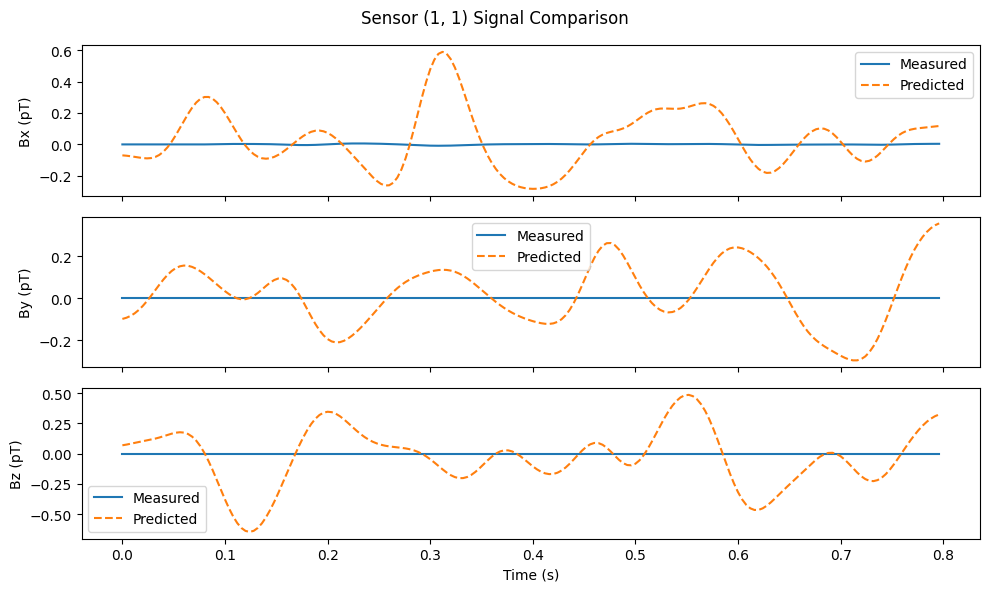

In [ ]:
# --- Predict fields at selected sensors ---
sensor_indices = [(1,1), (2,2), (3,1)]
predicted = predict_sensor_signal(sensor_indices, r0_all, m_all, sensor_positions_np, T)

# --- Plotting ---
sensor = (1,1)
pred = predicted[sensor]  # (3,T)

# Measured signal at (1,1)
measured = np.stack([Bx_meas[sensor], By_meas[sensor], Bz_meas[sensor]], axis=0)

time = np.arange(T) / 250  # Sampling rate 250Hz

fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
components = ['Bx', 'By', 'Bz']

for i in range(3):
    axs[i].plot(time, measured[i]*1e12, label='Measured')  # back to pT
    axs[i].plot(time, pred[i]*1e12, label='Predicted', linestyle='--')
    axs[i].set_ylabel(f'{components[i]} (pT)')
    axs[i].legend()

axs[-1].set_xlabel('Time (s)')
plt.suptitle(f'Sensor {sensor} Signal Comparison')
plt.tight_layout()
plt.show()

## Magentic Heart Vector

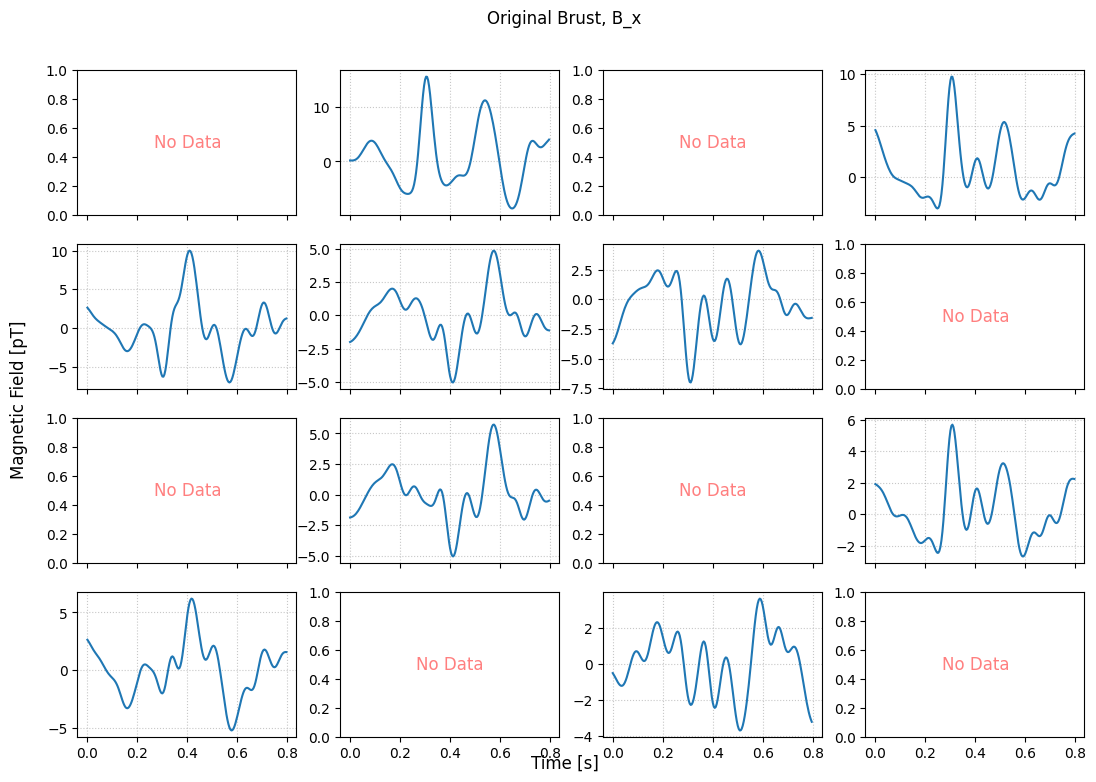

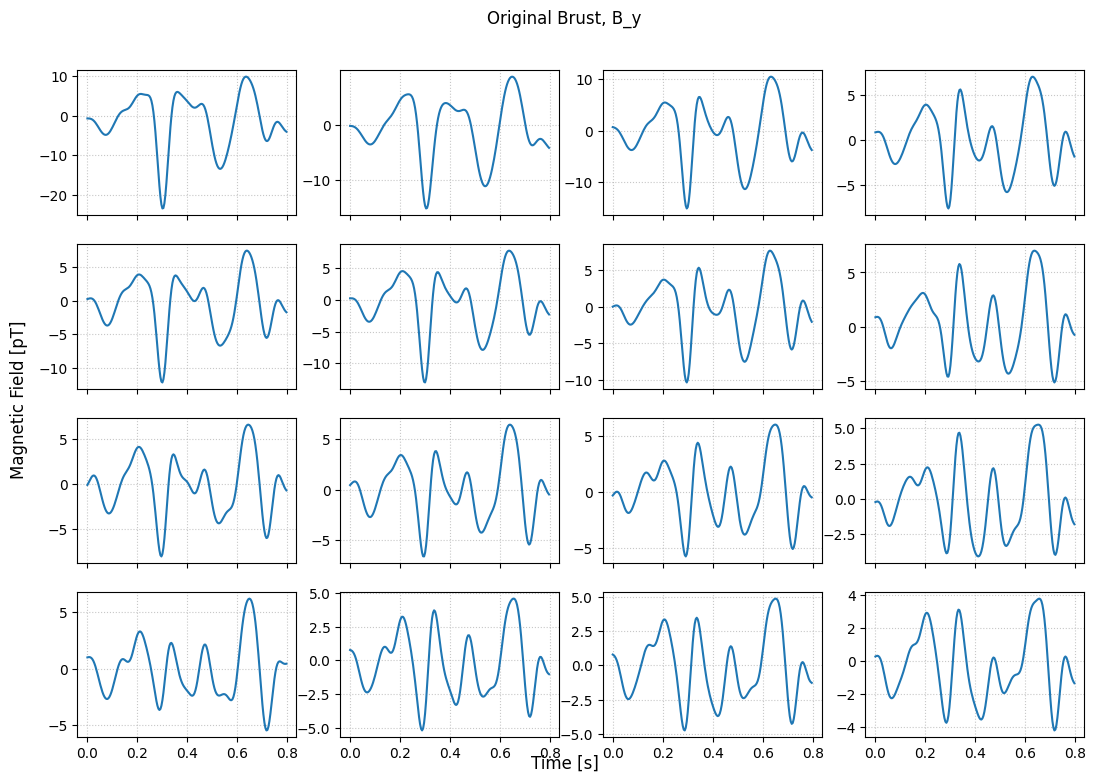

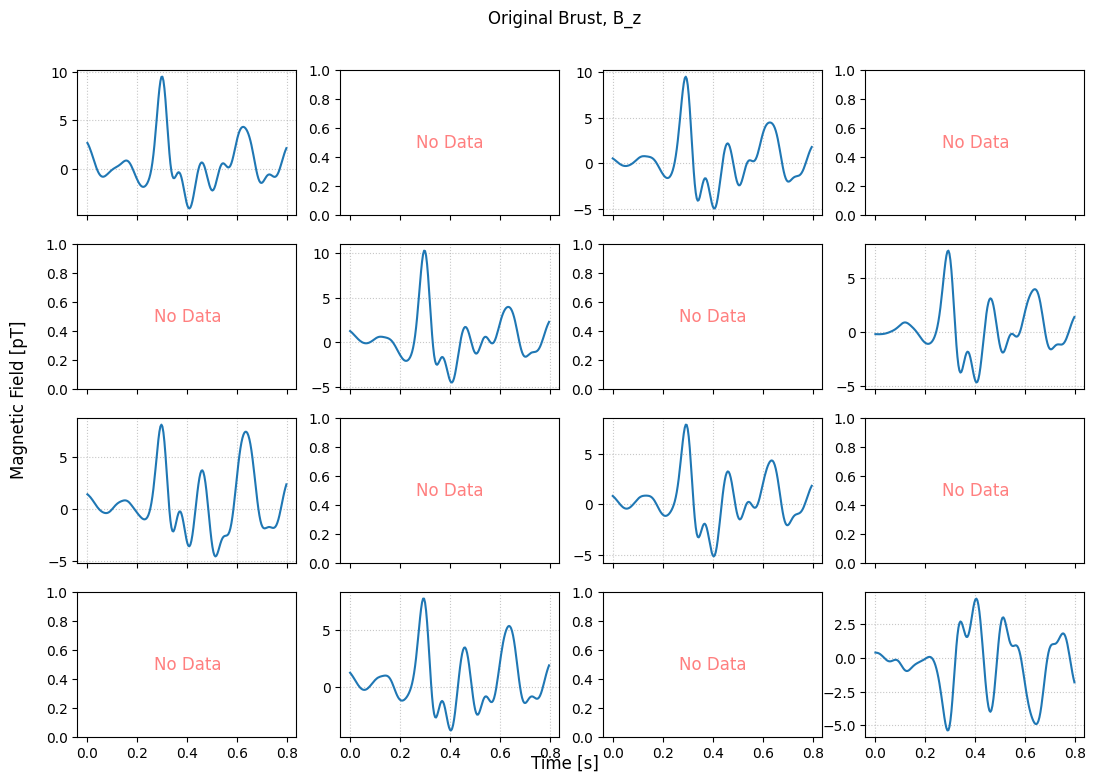

f1_data shape: (3, 200)

Channel Selection Results:
Channel   Mean Conf   P-Wave %    QRS %       T-Wave %    Plausibility   Final Score 
-------------------------------------------------------------------------------------
1         0.8785      29.50       14.50       46.50       0.2439         0.5945      
2         0.8204      0.00        16.00       44.50       0.2985         0.5906      
3         0.9295      0.00        0.00        0.00        0.2439         0.0000      

Best Channel Summary:
Channel   : 1
Mean Conf : 0.8785
Plausibility: 0.2439
Final Score: 0.5945
Segment Distribution:
  P-Wave % : 29.50%
  QRS %    : 14.50%
  T-Wave % : 46.50%


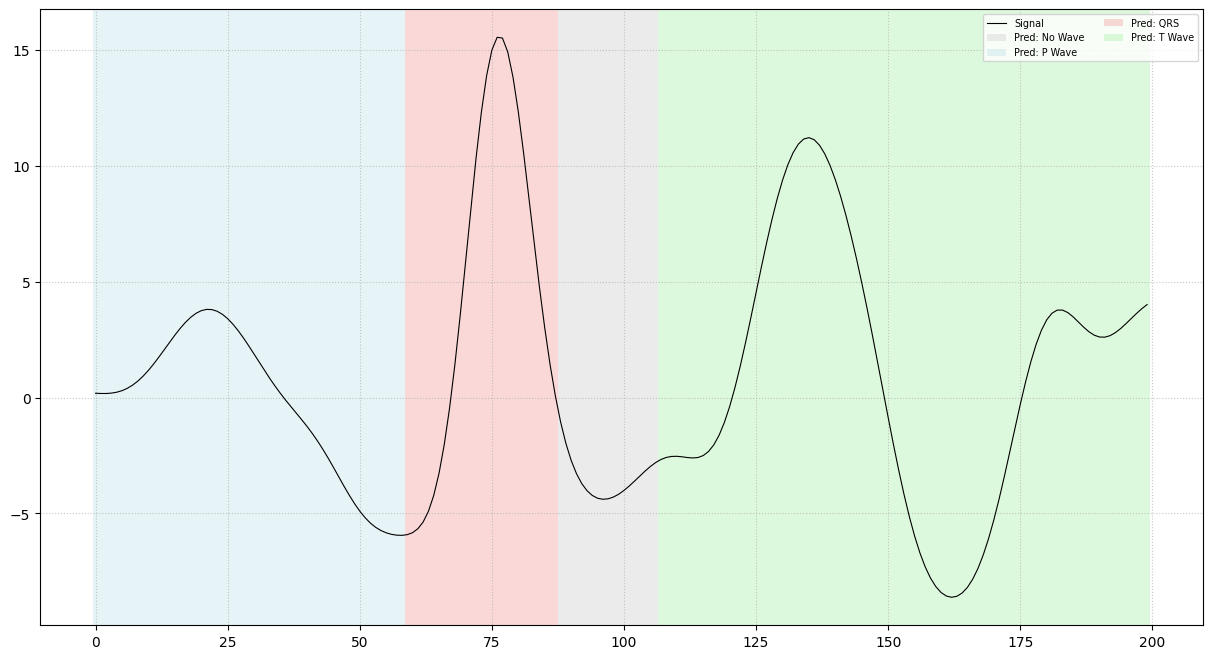

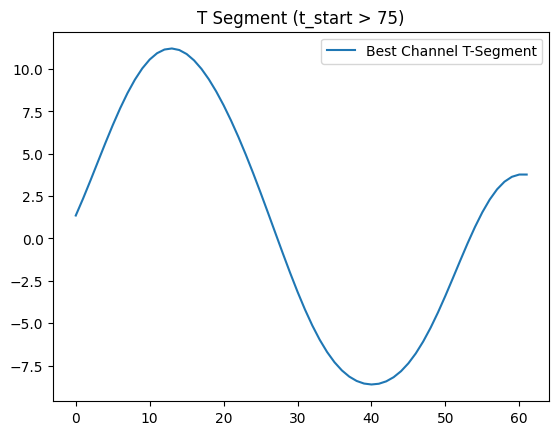

2025-05-02 14:15:29,548 - INFO - Metrics for xy-Projection: Area: 4.070
T-Dist: 14.08
S/E Ratio: 1.34
Compact: 0.0143
Angle: -43.2°
2025-05-02 14:15:29,606 - INFO - Metrics for xz-Projection: Area: 0.000
T-Dist: 9.86
S/E Ratio: 1.33
Compact: 0.0000
Angle: 0.0°
2025-05-02 14:15:29,631 - INFO - Metrics for yz-Projection: Area: 0.000
T-Dist: 10.04
S/E Ratio: 1.35
Compact: 0.0000
Angle: 180.0°


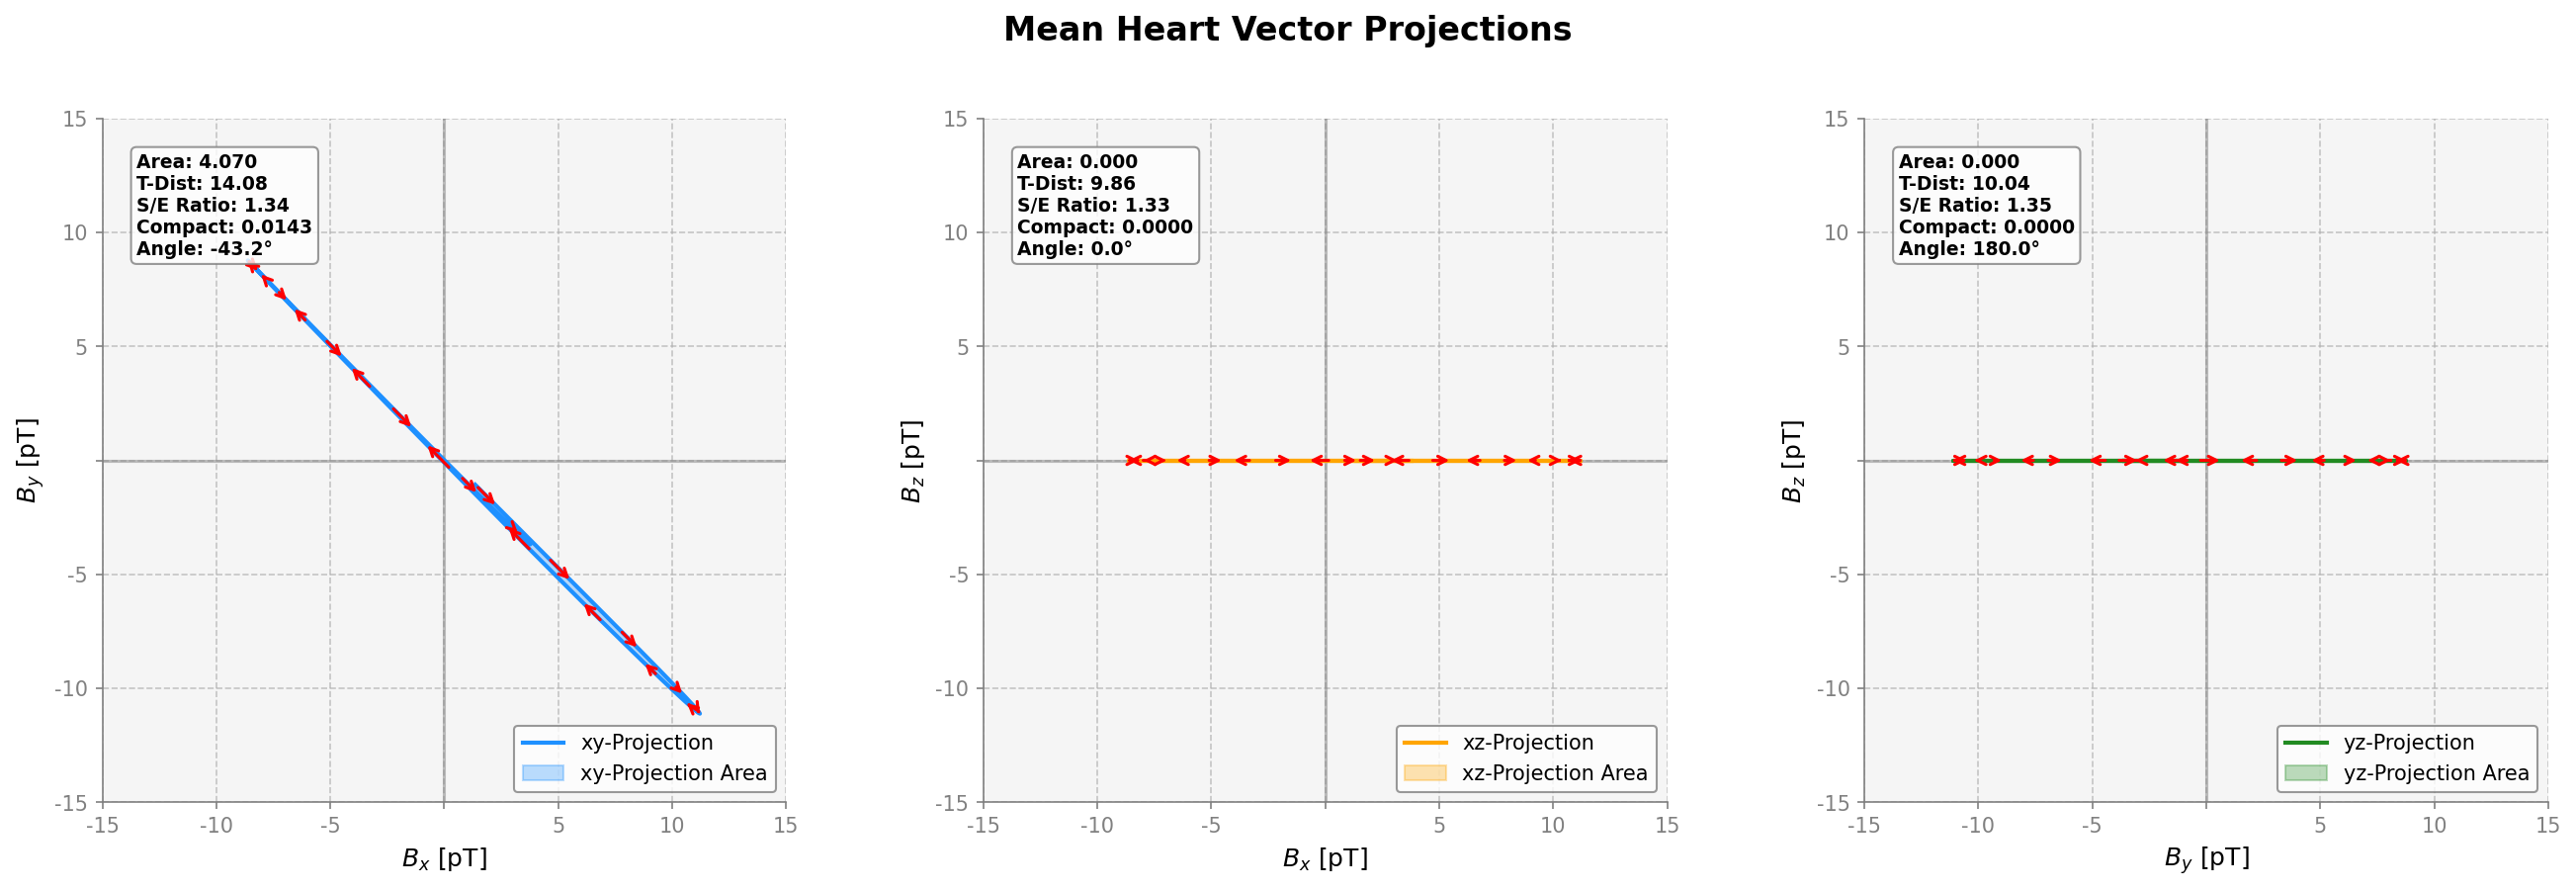

QRS start: 59, QRS end: 87, Fitted T peak: 162


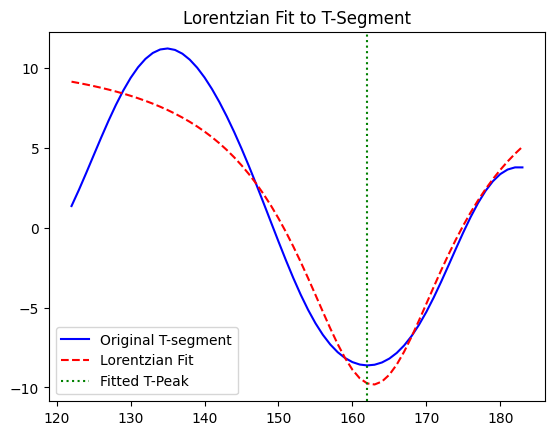

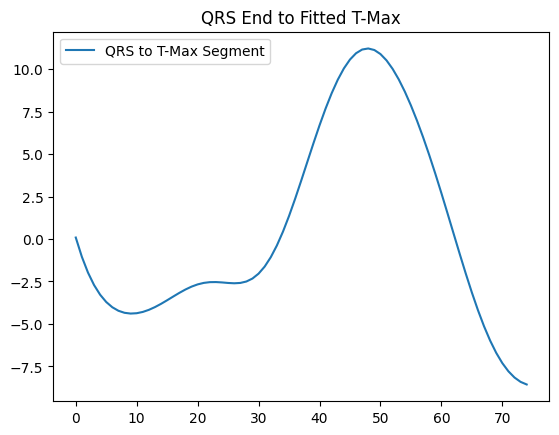

2025-05-02 14:15:30,221 - INFO - Metrics for xy-Projection: Area: 6.087
T-Dist: 15.86
S/E Ratio: 0.57
Compact: 0.0243
Angle: -44.5°
2025-05-02 14:15:30,244 - INFO - Metrics for xz-Projection: Area: 0.000
T-Dist: 11.13
S/E Ratio: 0.56
Compact: 0.0000
Angle: 0.0°
2025-05-02 14:15:30,265 - INFO - Metrics for yz-Projection: Area: 0.000
T-Dist: 11.29
S/E Ratio: 0.57
Compact: 0.0000
Angle: 180.0°


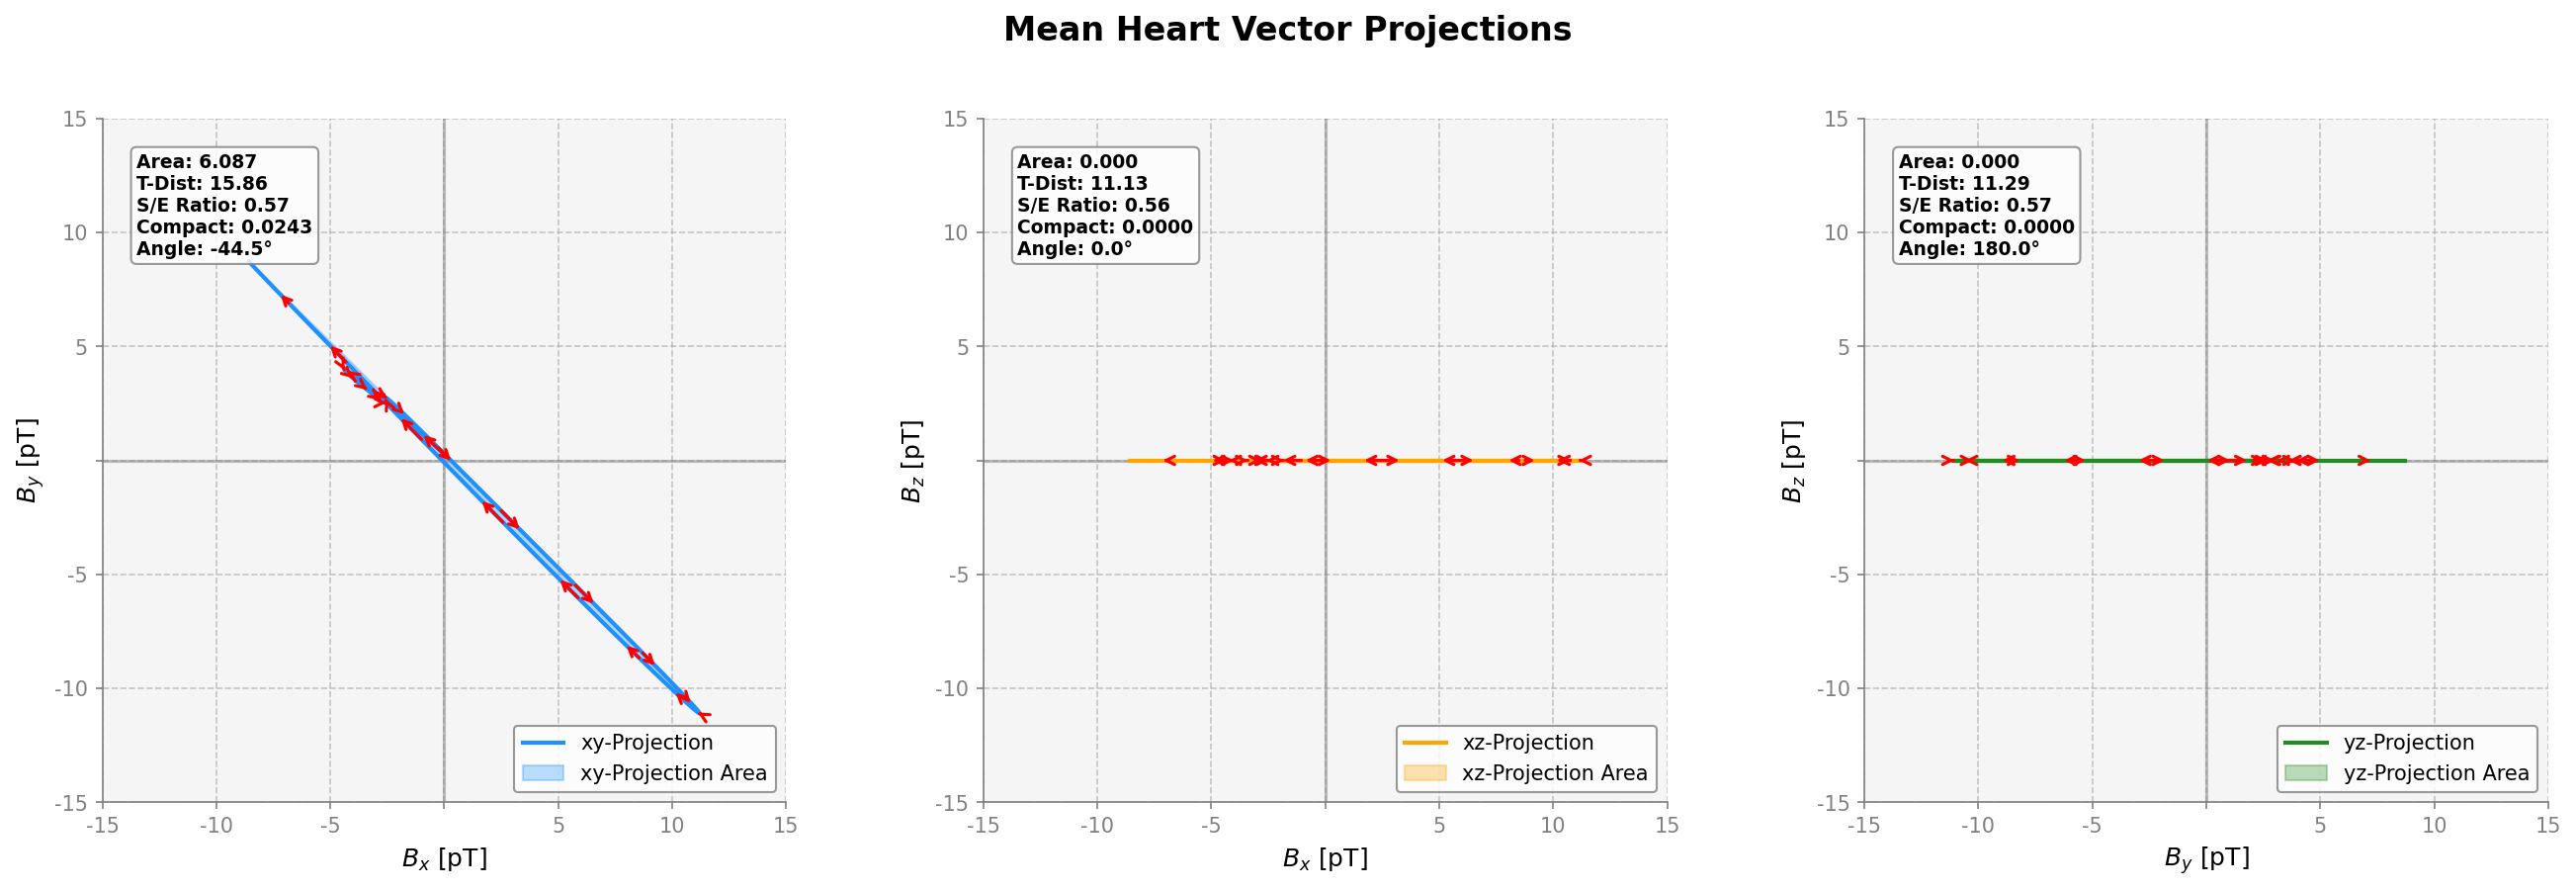

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# --- Load data ---
x_data, y_data, z_data = analysis.get_field_directions(avg_channels, key)

analysis.plot4x4(x_data, time_window, f"Original {key}, B_x")
analysis.plot4x4(y_data, time_window, f"Original {key}, B_y")
analysis.plot4x4(z_data, time_window, f"Original {key}, B_z")

# Get field directions
x_data, y_data, z_data = analysis.get_field_directions(avg_channels, key)

f1_data = np.array([x_data[0, 0, :], y_data[0, 0, :], z_data[0, 0, :]])
print(f"f1_data shape: {f1_data.shape}")

# Find cleanest channel
best_channel, (labels, data, confidence) = analysis.find_cleanest_channel(
    f1_data, resample=False, confidence_weight=0.5, plausibility_weight=0.5
)

analysis.plot_segmented_signal(f1_data[best_channel], labels[best_channel])

# ----------------------------
# Get T-wave segment
# ----------------------------
mask_t = labels[best_channel] == 3
mask_t[:75] = False  # Ignore everything before index 75!

t_segment = None
if np.any(mask_t):
    t_indices = np.where(mask_t)[0]
    t_start = t_indices[0] + 15
    t_end = t_indices[-1] -15

    t_segment = f1_data[:, t_start:(t_end)]

    plt.figure()
    plt.plot(t_segment[best_channel], label="Best Channel T-Segment")
    plt.legend()
    plt.title("T Segment (t_start > 75)")
    plt.show()

    analysis.plot_all_heart_vector_projections(t_segment)
else:
    print("No T-wave segment found!")

# ----------------------------
# Segment from end of QRS to max of T using Lorentzian fit
# ----------------------------
mask_qrs = labels[best_channel] == 2
mask_qrs[-50:] = False 

if np.any(mask_qrs) and t_segment is not None:
    t_start_qrs = np.where(mask_qrs)[0][0] 
    t_end_qrs = np.where(mask_qrs)[0][-1] 

    # Define search window after QRS
    search_start = t_end_qrs + 15

    # --- Lorentzian Fit ---
    def lorentzian(x, x0, gamma, A, y0):
        return A * gamma**2 / ((x - x0)**2 + gamma**2) + y0

    y_data = t_segment[best_channel]
    x_data = np.arange(len(y_data))

    # Initial guess for Lorentzian parameters
    x0_init = len(y_data) // 2
    gamma_init = 10
    A_init = np.max(y_data) - np.min(y_data)
    y0_init = np.min(y_data)

    try:
        popt, _ = opt.curve_fit(lorentzian, x_data, y_data, p0=[x0_init, gamma_init, A_init, y0_init])
        fitted_center = int(popt[0])
        max_t = t_start + fitted_center  # Absolute index in the full signal

        print(f"QRS start: {t_start_qrs}, QRS end: {t_end_qrs}, Fitted T peak: {max_t}")

        # Plot fitted curve
        y_fit = lorentzian(x_data, *popt)
        plt.figure()
        plt.plot(x_data + t_start, y_data, label="Original T-segment", color='blue')
        plt.plot(x_data + t_start, y_fit, label="Lorentzian Fit", linestyle='--', color='red')
        plt.axvline(max_t, color='green', linestyle=':', label="Fitted T-Peak")
        plt.title("Lorentzian Fit to T-Segment")
        plt.legend()
        plt.show()

        # Segment from QRS end to fitted T peak
        segment_qrs_to_tmax = f1_data[:, t_end_qrs:max_t]

        plt.figure()
        plt.plot(segment_qrs_to_tmax[best_channel], label="QRS to T-Max Segment")
        plt.legend()
        plt.title("QRS End to Fitted T-Max")
        plt.show()

        analysis.plot_all_heart_vector_projections(segment_qrs_to_tmax)

    except Exception as e:
        print(f"Lorentzian fit failed: {e}")
else:
    print("QRS segment or T-segment not found!")
